# Generates Mobility file for inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if '..' not in sys.path:
    sys.path.append('..')
    
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import os

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

### Settings for synthetic mobility data generation

Import __one__ `town_settings` file. The following variables will be imported by the `import *` command
* `town_name`
* `population_path`
* `sites_path`
* `bbox`
* `population_per_age_group`
* `region_population`
* `town_population`
* `daily_tests_unscaled`
* `household_info`

In [3]:
# from lib.settings.town_settings_kaiserslautern import *
# from lib.settings.town_settings_ruedesheim import *
# from lib.settings.town_settings_tirschenreuth import *
# from lib.settings.town_settings_tubingen import *
from lib.settings.town_settings_sanfrancisco import *

# from lib.settings.town_settings_lausanne import *
# from lib.settings.town_settings_locarno import *
# from lib.settings.town_settings_lucerne import *
# from lib.settings.town_settings_jura import *

In [4]:
# Downsampling factor of population and sites
downsample = 200

# Country for different age groups
country = 'US' # 'GER', 'CH'

# Set the population generation mode.
# 3 options available: custom | random | heuristic
population_by = 'custom'

### Nothing should be changed below

---

#### Town details

In [5]:
# Downsample population 
population_per_age_group = np.round(
    population_per_age_group * (town_population / (downsample * region_population))).astype('int').tolist()

print(f'Population per age group: {population_per_age_group}')

Population per age group: [194, 296, 154, 263, 1646, 835, 682, 181]


In [21]:

model_essential=True
if model_essential == True:
    '''Hack: Must be changed if want to model essential workers not in SF'''
    from lib.settings.town_settings_sanfrancisco import _essential_prop_per_age_group, _worker_mobility

    # proportion of total population that are essential workers
    prop_essential_total = 0.6
    num_worker_types = 4

    essential_prop_per_age_group = _essential_prop_per_age_group(prop_essential_total)
    num_essential_per_age_group = np.rint(essential_prop_per_age_group*population_per_age_group)
    strFormat = len(essential_prop_per_age_group) * '{:.2%} '
    print(f'Proportion of age groups that are essential workers:\n {strFormat.format(*essential_prop_per_age_group)}')
    print(f'Essential workers per age group:\n {num_essential_per_age_group}')
    print(f'Proportion of essential workers to total: {float((num_essential_per_age_group).sum())/sum(population_per_age_group):.3%}')
else:
    essential_prop_per_age_group = None
    num_worker_types = None

Proportion of age groups that are essential workers:
 0.00% 0.00% 16.55% 77.64% 69.73% 76.35% 74.75% 0.00% 
Essential workers per age group:
 [   0.    0.   25.  204. 1148.  638.  510.    0.]
Proportion of essential workers to total: 59.398%


#### Extracted site data

* `site_loc`: list of site coordinates
* `site_type`: list of site category
* `site_dict`: helper dictionary with real name (string) of each site category (int)
* `density_site_loc`: list of site coordinates of specific type to be based on to generate population density

To generate sites of arbitrary sites for a given city, the following function sends queries to OpenStreetMap. In order to use it for additional types of sites, you need to specify queries in the Overpass API format. For more information, check the existing queries in **/lib/data/queries/**, https://wiki.openstreetmap.org/wiki/Overpass_API and http://overpass-turbo.eu/.

We separatelly use a query returning all buildings in a town to heuristically generate population density in the next steps if no real population density data is provided. An extra query is required for this purpose and it should be given as a **site_based_density_file** argument.

In [7]:
# This block sends queries to OpenStreetMap
# Make sure you have a working internet connection
# If an error occurs during execution, try executing again 
# If the call times out or doesn't finish, try restarting your internet connection by e.g. restarting your computer
site_files=[]
for root,dirs,files in os.walk(sites_path):
    for f in files:
        if f.endswith(".txt") and f != 'buildings.txt':
            site_files.append(sites_path+f)

site_loc, site_type, site_dict, density_site_loc = generate_sites(bbox=bbox, query_files=site_files,sites_path=sites_path,
                                site_based_density_file=sites_path+'buildings.txt')

Query 1 OK.
Query 2 OK.
Query 3 OK.
Query 4 OK.
Query 5 OK.


In [8]:
# before downsampling
print(site_dict)
print('Number of sites: ',np.sum(np.array(site_type)==0),
                          np.sum(np.array(site_type)==1),
                          np.sum(np.array(site_type)==2),
                          np.sum(np.array(site_type)==3))

{0: 'education', 1: 'office', 2: 'social', 3: 'supermarket'}
Number of sites:  370 4910 3159 383


#### Site visualization

In [9]:
# ill = MapIllustrator()
# sitemap = ill.sites_map(bbox=bbox, site_loc=site_loc, site_type=site_type, site_dict = site_dict, map_name=f'{town_name}_site_distribution')
# sitemap

#### Generate home location based on various options

* `home_loc`: list of home coordinates
* `people_age`: list of age category 
* `home_tile`: list of map tile to which each home belongs
* `tile_loc`: list tile center coordinates

The following three options generate a population distribution across a geographical area consisting of tiles (square boxes) of specific resolution. More information about tile sizes can be found in https://wiki.openstreetmap.org/wiki/Zoom_levels. 

In [10]:
if region_population == town_population:
    tile_level = 15
else:
    tile_level = 16

if population_by == 'custom':
    # generate population across tiles based on density input
    print('Tile level: ', tile_level)
    home_loc, people_age, home_tile, tile_loc, people_household, worker_types = generate_population(
        density_file=population_path, bbox=bbox,
        population_per_age_group=population_per_age_group, 
        household_info=household_info, tile_level=tile_level, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group,
        num_worker_types=num_worker_types)
    
elif population_by == 'random':
    # generate population across tiles uniformly at random
    home_loc, people_age, home_tile, tile_loc, people_household, worker_types = generate_population(
        bbox=bbox, population_per_age_group=population_per_age_group,
        tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group,
        num_worker_types=num_worker_types)

elif population_by == 'heuristic':
    # generate population across tiles proportional to buildings per tile
    home_loc, people_age, home_tile, tile_loc, people_household, worker_types = generate_population(
        bbox=bbox, density_site_loc=density_site_loc,
        population_per_age_group=population_per_age_group, tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group,
        num_worker_types=num_worker_types)

Tile level:  15


In [14]:
print(f'Num essential workers: {(np.array(worker_types)!=-1).sum()}/{len(worker_types)}')

Num essential workers: 2520/4254


Text(0, 0.5, 'Number of Households')

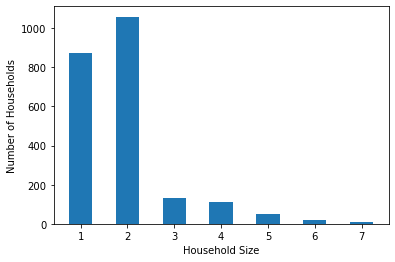

In [15]:
unique_household, counts_household = np.unique(people_household, return_counts=True)
plt.hist(counts_household,bins=range(1,9),align='left',rwidth=0.5)
plt.xlabel('Household Size')
plt.ylabel('Number of Households')

#### Home visualization

In [16]:
# homemap = ill.population_map(bbox=bbox, home_loc=home_loc, map_name=f'{town_name}_population_distribution')
# homemap # zoom in to see details

Downsample sites as given by settings

In [17]:
# site_downsample = downsample
site_downsample = 100

if site_downsample > 1:
#     np.random.seed(42)
#     # downsample sites like populatoin
#     idx = np.random.choice(len(site_loc), size=int(len(site_loc) / site_downsample), 
#                            replace=False, p=np.ones(len(site_loc)) / len(site_loc))

#     site_loc, site_type = np.array(site_loc)[idx].tolist(), np.array(site_type)[idx].tolist()

    # Zihan: new downsampling method so that each type is downsampled by the same value
    site_loc_downsampled = []
    site_type_downsampled = []
    for i in range(len(site_dict)):
        curr_type_all = np.zeros(len(site_type))
        curr_type_all[np.array(site_type)==i] = 1
        idx = np.random.choice(len(site_type), size=int(np.sum(np.array(site_type)==i) / site_downsample), 
                               replace=False, p=curr_type_all / np.sum(np.array(site_type)==i))
        site_loc_downsampled = site_loc_downsampled + np.array(site_loc)[idx].tolist()
        site_type_downsampled = site_type_downsampled + np.array(site_type)[idx].tolist()
    site_loc = site_loc_downsampled
    site_type = site_type_downsampled

In [18]:
print(f'Number of sites: ', len(site_loc))
print(f'Site types:      ', site_dict)
print('Number of sites: ',np.sum(np.array(site_type)==0),
                          np.sum(np.array(site_type)==1),
                          np.sum(np.array(site_type)==2),
                          np.sum(np.array(site_type)==3))

Number of sites:  86
Site types:       {0: 'education', 1: 'office', 2: 'social', 3: 'supermarket'}
Number of sites:  3 49 31 3


Compute pairwise distances between all tile centers and all sites

In [19]:
tile_site_dist = compute_distances(site_loc, tile_loc)

#### Specify synthetic mobility patterns

Here we specify the patterns of mobility used for generating the synthetic traces based on the above home and site locations. Note that this is a general framework and can by arbitrarilty extended to any desired site numbers or types. See below for an example used in the first version of our paper.

In [25]:
# e.g. line 0 corresponds to age 0-4 in Germany
# a lot of eduction (kindergarden), some social, no public transport, no office, no supermarket
# the age groups are chosen to match the age groups used in case data by national authorities
# GERMANY
if country == 'GER':
    mob_rate_per_age_per_type = [
        [5, 1, 0, 0, 0], # 0-4
        [5, 2, 3, 0, 0], # 5-14
        [2, 2, 3, 3, 1], # 15-34
        [0, 2, 1, 5, 1], # 35-59
        [0, 3, 2, 0, 1], # 60-79
        [0, 2, 1, 0, 1]]  # 80+
    dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
    variety_per_type = [1, 10, 5, 1, 2]

# SWITZERLAND
elif country == 'CH':
    mob_rate_per_age_per_type = [
       [5, 1, 0, 0, 0], # 0-9
       [5, 2, 3, 0, 0], # 10-19
       [2, 2, 3, 3, 1], # 20-29
       [2, 2, 3, 3, 1], # 30-39
       [0, 2, 1, 5, 1], # 40-49
       [0, 2, 1, 5, 1], # 50-59
       [0, 3, 2, 0, 1], # 60-69
       [0, 3, 2, 0, 1], # 70-79
       [0, 2, 1, 0, 1]] # 80+
    dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
    variety_per_type = [1, 10, 5, 1, 2]
    
elif country == 'US':
    #  {0: 'education', 1: 'office', 2: 'social', 3: 'supermarket'}
    mob_rate_per_age_per_type = [
         [5,    0,    0,   0],    # 0-5
         [5,    0,    0,   0],    # 5-14
         [5,    0,    3.6, 0.22], # 15-19
         [1.48, 3.52, 3.6, 0.21], # 20-24
         [0,    5,    3.6, 0.27], # 25-44
         [0,    5,    3.6, 0.36], # 45-59
         [0,    0,    3.6, 0.35], # 60-79
         [0,    0,    3.6, 0.35]] # 80+

    dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
    variety_per_type = [1, 1, 10, 2]
    
    if model_essential==True:
        wtype='education'
#         essential_mob_rate_per_type, essential_dur_mean_per_type, essential_variety_per_type = mob_rate_per_age_per_type[0], dur_mean_per_type, variety_per_type
#         essential_mob_rate_per_type, essential_dur_mean_per_type, essential_variety_per_type = _essential_mobility(wtype)
        worker_mob_rate_per_types, worker_dur_mean_per_types, worker_variety_per_types = _worker_mobility()
        print(f"MRPAPT: {mob_rate_per_age_per_type}, DMPT: {dur_mean_per_type}, VPT: {variety_per_type}")
        print(f"WMRPT: {worker_mob_rate_per_types}, WDMRT: {worker_dur_mean_per_types}, WVPT: {worker_variety_per_types}")
    else:
        essential_mob_rate_per_type, essential_dur_mean_per_type, essential_variety_per_type = None, None, None
else:
    raise ValueError('Invalid country code.')
    
# convert to average visits per hour per week, to be compatible with simulator
mob_rate_per_age_per_type = np.divide(np.array(mob_rate_per_age_per_type), (24.0 * 7))

MRPAPT: [[5, 0, 0, 0], [5, 0, 0, 0], [5, 0, 3.6, 0.22], [1.48, 3.52, 3.6, 0.21], [0, 5, 3.6, 0.27], [0, 5, 3.6, 0.36], [0, 0, 3.6, 0.35], [0, 0, 3.6, 0.35]], DMPT: [5.0, 5.0, 0.64, 0.4], VPT: [1, 1, 10, 2]
WMRPT: [[5.0, 0.0, 3.6, 0.27], [0.0, 5.0, 3.6, 0.27], [0.0, 0.0, 5.0, 0.27], [0.0, 0.0, 3.6, 5.0]], WDMRT: [[5.0, 0.1, 0.64, 0.4], [0.1, 5.0, 0.64, 0.4], [0.1, 0.1, 5.0, 0.4], [0.1, 0.1, 0.64, 5.0]], WVPT: [[1, 1, 10, 2], [1, 1, 10, 2], [1, 1, 10, 2], [1, 1, 10, 2]]


Set `delta`; the setting for delta is explained in the paper.

In [26]:
# time horizon
delta  = 4.6438 # as set by distributions

In [27]:
print('Population (by Age): ', population_per_age_group)
print('Sites (by type):     ',  [(np.array(site_type) == i).sum() for i in range(len(mob_rate_per_age_per_type[0]))])

print('Total:', sum(population_per_age_group), len(site_type))

Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
Sites (by type):      [3, 49, 31, 3]
Total: 4251 86


Save arguments for the class object instantiation to be able to initiate `MobilitySimulator` on the fly during inference. That is more efficient than pickling in some cases.

In [28]:
kwargs = dict(
    home_loc=home_loc, 
    people_age=people_age, 
    site_loc=site_loc, 
    num_people_unscaled=town_population,
    region_population=region_population,
    site_type=site_type, 
    site_dict=site_dict, 
    downsample=downsample,
    mob_rate_per_age_per_type=mob_rate_per_age_per_type,
    daily_tests_unscaled=daily_tests_unscaled, 
    dur_mean_per_type=dur_mean_per_type, 
    variety_per_type=variety_per_type, 
    delta=delta,
    home_tile=home_tile, 
    tile_site_dist=tile_site_dist, 
    people_household=people_household,
    worker_types=worker_types,
    worker_mob_rate_per_types=worker_mob_rate_per_types,
    worker_dur_mean_per_types=worker_dur_mean_per_types,
    worker_variety_per_types=worker_variety_per_types)

if model_essential==False:
    outfile = f'lib/mobility/{town_name}_settings_{downsample}.pk'
else:
    outfile = f'lib/mobility/{town_name}_settings_{downsample}_{wtype}_{int(prop_essential_total*100)}pct.pk'
with open(outfile, 'wb') as fp:
    pickle.dump(kwargs, fp)
print(f'Saved mobility settings to {outfile}')

Saved mobility settings to lib/mobility/San_Francisco_settings_200_education_60pct.pk


Create mobility traces as above, or comment in the last section below to specify fully artifial traces.

In [29]:
mob = MobilitySimulator(**kwargs)
mob.verbose = True

In [30]:
max_time = 17 * 24.0 # e.g. 17 days
%time mob.simulate(max_time=max_time, seed=12345)
# %time mob.to_pickle(f'tu_mobility_{downsample_population}_{downsample_sites}.pk')

Simulate mobility for 408.00 time units... Simulated 147697 visits.
Find contacts... 
CPU times: user 3min 14s, sys: 25.7 s, total: 3min 40s
Wall time: 3min 46s


# Laura Experiments

In [71]:
# def _num_interactions(contact_list):
#     interactions = 0
#     for contact in contact_list:
#         interactions += 

def num_contacts_and_interactions(mob):
    num_contacts = np.array([len(mob.contacts[i]) for i in mob.contacts])
    num_interactions = np.array([sum([len(mob.contacts[i][j]) for j in mob.contacts[i]]) for i in mob.contacts])
    return num_contacts, num_interactions

num_contacts, num_interactions = num_contacts_and_interactions(mob)
print(num_contacts, num_interactions)
print(np.unique(num_interactions))

[329 396 278 ... 276 219 217] [381 536 284 ... 334 221 257]
[  31   38   39 ... 3219 3263 3277]


In [55]:
len(np.unique(list(mob.contacts[3].keys())))

263

In [56]:
len(mob.contacts[3].keys())

263

In [62]:
mob.contacts[3]

defaultdict(interlap.InterLap,
            {618: <interlap.InterLap at 0x7fe815e3acd0>,
             683: <interlap.InterLap at 0x7fe815e4c910>,
             841: <interlap.InterLap at 0x7fe815e9e050>,
             888: <interlap.InterLap at 0x7fe815eb8e90>,
             1724: <interlap.InterLap at 0x7fe816124d50>,
             1760: <interlap.InterLap at 0x7fe816166510>,
             1834: <interlap.InterLap at 0x7fe8161a5150>,
             1882: <interlap.InterLap at 0x7fe8161da290>,
             2563: <interlap.InterLap at 0x7fe8163f6bd0>,
             2723: <interlap.InterLap at 0x7fe8164bfc90>,
             2740: <interlap.InterLap at 0x7fe8164da0d0>,
             2790: <interlap.InterLap at 0x7fe81651ab10>,
             2888: <interlap.InterLap at 0x7fe8165b6a90>,
             2933: <interlap.InterLap at 0x7fe8165c7f50>,
             3663: <interlap.InterLap at 0x7fe816765450>,
             3951: <interlap.InterLap at 0x7fe8168dcb90>,
             4353: <interlap.InterLap at 0x7f

In [67]:
import pdb
# len(mob.contacts[3][841])
for person_i in mob.contacts:
    i_contacts = mob.contacts[person_i]
    for person_j in i_contacts:
        inter = i_contacts[person_j]
        if len(inter)>1:
            pdb.set_trace()
            

> <ipython-input-67-043a0dc2911a>(5)<module>()
      3 for person_i in mob.contacts:
      4     i_contacts = mob.contacts[person_i]
----> 5     for person_j in i_contacts:
      6         inter = i_contacts[person_j]
      7         if len(inter)>1:

ipdb> len(inter)
2
ipdb> inter
ipdb> inter[0]
*** TypeError: 'InterLap' object is not subscriptable
ipdb> inter._iset
[Contact(t_from=181.40921495309013, t_to=181.71071169279372, indiv_i=0, indiv_j=4095, site=7, duration=0.3014967397035946, id_tup=(6, 7)), Contact(t_from=343.4363672678988, t_to=343.6778991244138, indiv_i=0, indiv_j=4095, site=86, duration=0.24153185651499598, id_tup=(12, 15))]
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> <ipython-input-67-043a0dc2911a>(5)<module>()
      3 for person_i in mob.contacts:
      4     i_contacts = mob.contacts[person_i]
----> 5     for person_j in i_contacts:
      6         inter = i_contacts[person_j]
      7         if len(inter)>1:

ipdb> q


BdbQuit: 

In [65]:
def household_size(mob):
    people_household = mob.people_household
    unique_household, counts_household = np.unique(people_household, return_counts=True)
    f = lambda x: counts_household[x]
    household_size = f(people_household)
    return household_size
    # plt.hist(household_size,bins=range(1,9),align='left',rwidth=0.5)
    # plt.xlabel('Household Size')
    # plt.ylabel('Number of Households')

In [36]:
len(household_size)

8499